# 14.2 Fixed Effects Estimation

**Chapter**: 14 - Panel Data and Fixed Effects  
**Section**: 2 - The Within Transformation  
**Facure Source**: 14-Panel-Data-and-Fixed-Effects.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Demeaning Trick](#11-the-demeaning-trick)
   - 1.2 [Why It Works](#12-why-it-works)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Within Transformation](#21-the-within-transformation)
   - 2.2 [Degrees of Freedom and Standard Errors](#22-degrees-of-freedom-and-standard-errors)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Manual Demeaning (Pedagogical)](#31-manual-demeaning-pedagogical)
   - 3.2 [Production Implementation with PanelOLS](#32-production-implementation-with-panelols)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

# Panel data library
from linearmodels.datasets import wage_panel
from linearmodels.panel import PanelOLS

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: The within transformation is the computational heart of fixed effects. Understanding how demeaning eliminates unit-specific heterogeneity is essential for explaining FE in interviews.

### 1.1 The Demeaning Trick

The fixed effects model includes a dummy for each unit:

$$
Y_{it} = \beta T_{it} + \gamma' X_{it} + \alpha_i + \epsilon_{it}
$$

**Problem**: With 545 individuals, we'd have 545 dummy variables—computationally inefficient.

**Solution**: The **within transformation** (demeaning) achieves the same result without computing 545 dummies.

**Procedure**:
1. For each variable, compute the individual mean: $\bar{Y}_i = \frac{1}{T} \sum_t Y_{it}$
2. Subtract the mean from each observation: $\tilde{Y}_{it} = Y_{it} - \bar{Y}_i$
3. Run OLS on the demeaned data

### 1.2 Why It Works

**Key insight**: Regressing on a dummy is equivalent to computing the mean for that group.

When we demean:
- $\tilde{\alpha}_i = \alpha_i - \bar{\alpha}_i = \alpha_i - \alpha_i = 0$

The unit fixed effect vanishes! All time-invariant heterogeneity is swept away.

★ Insight ─────────────────────────────────────
- Demeaning removes everything that's constant within a unit
- This includes BOTH measured AND unmeasured time-invariant confounders
- Only within-unit variation remains for estimation
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The Within Transformation

**Model**:
$$
Y_{it} = \beta T_{it} + \gamma' X_{it} + \alpha_i + \epsilon_{it}
$$

**Step 1**: Take the time average for each unit:
$$
\bar{Y}_i = \beta \bar{T}_i + \gamma' \bar{X}_i + \alpha_i + \bar{\epsilon}_i
$$

Note: $\bar{\alpha}_i = \alpha_i$ because $\alpha_i$ is constant over time.

**Step 2**: Subtract the time-averaged equation from the original:
$$
(Y_{it} - \bar{Y}_i) = \beta (T_{it} - \bar{T}_i) + \gamma' (X_{it} - \bar{X}_i) + (\alpha_i - \alpha_i) + (\epsilon_{it} - \bar{\epsilon}_i)
$$

**Result**: The within-transformed model:
$$
\boxed{\tilde{Y}_{it} = \beta \tilde{T}_{it} + \gamma' \tilde{X}_{it} + \tilde{\epsilon}_{it}}
$$

where tildes denote demeaned variables: $\tilde{Y}_{it} = Y_{it} - \bar{Y}_i$.

**Observation**: $\alpha_i$ has vanished. The within estimator is simply OLS on the demeaned data.

### 2.2 Degrees of Freedom and Standard Errors

**DoF adjustment**: Demeaning effectively estimates $N$ parameters (one mean per unit), so:
$$
\text{DoF} = NT - N - K = N(T-1) - K
$$

where $K$ is the number of regressors.

**Clustered standard errors**: With panel data, errors are often correlated within units:
$$
\text{Cov}(\epsilon_{it}, \epsilon_{is}) \neq 0 \text{ for } t \neq s
$$

**Solution**: Cluster standard errors by entity.

**Theorem (Cluster-Robust Variance)**:
$$
\hat{V}_{\text{cluster}} = (\tilde{X}'\tilde{X})^{-1} \left( \sum_{i=1}^N \tilde{X}_i' \hat{\epsilon}_i \hat{\epsilon}_i' \tilde{X}_i \right) (\tilde{X}'\tilde{X})^{-1}
$$

This is robust to arbitrary within-cluster correlation.

---

## 3. Numeric Demonstration

### 3.1 Manual Demeaning (Pedagogical)

Let's implement the within transformation step by step.

In [2]:
# Load data
data = wage_panel.load()

# Define variables
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

print("Variables for analysis:")
print(f"  Outcome (Y):   {Y} (log wages)")
print(f"  Treatment (T): {T}")
print(f"  Controls (X):  {X[1:]}")

Variables for analysis:
  Outcome (Y):   lwage (log wages)
  Treatment (T): married
  Controls (X):  ['expersq', 'union', 'hours']


In [3]:
# Step 1: Compute individual means
mean_data = data.groupby("nr")[X + [Y]].mean()

print("Individual-level means (first 5 units):")
print(mean_data.head().round(4))

Individual-level means (first 5 units):
     married  expersq  union     hours  lwage
nr                                           
13    0.0000  25.5000 0.1250 2807.6250 1.2557
17    0.0000  61.5000 0.0000 2504.1250 1.6378
18    1.0000  61.5000 0.0000 2350.5000 2.0344
45    0.1250  35.5000 0.2500 2225.8750 1.7737
110   0.5000  77.5000 0.1250 2108.0000 2.0551


In [4]:
# Step 2: Demean the data (within transformation)
demeaned_data = (
    data
    .set_index("nr")  # Set index to individual identifier
    [X + [Y]]
    - mean_data       # Subtract individual means
)

print("Demeaned data (first 10 rows):")
print(demeaned_data.head(10).round(4))

# Verify: demeaned data should have mean ~0 for each individual
print(f"\nVerification: Mean of demeaned lwage for person 13: {demeaned_data.loc[13, 'lwage'].mean():.10f}")

Demeaned data (first 10 rows):
    married  expersq   union     hours   lwage
nr                                            
13   0.0000 -24.5000 -0.1250 -135.6250 -0.0581
13   0.0000 -21.5000  0.8750 -487.6250  0.5974
13   0.0000 -16.5000 -0.1250  132.3750  0.0888
13   0.0000  -9.5000 -0.1250  152.3750  0.1776
13   0.0000  -0.5000 -0.1250  263.3750  0.3125
13   0.0000  10.5000 -0.1250   56.3750  0.4442
13   0.0000  23.5000 -0.1250  186.3750 -1.9759
13   0.0000  38.5000 -0.1250 -167.6250  0.4135
17   0.0000 -45.5000  0.0000  -20.1250  0.0382
17   0.0000 -36.5000  0.0000  299.8750 -0.1194

Verification: Mean of demeaned lwage for person 13: 0.0000000000


In [5]:
# Step 3: Run OLS on demeaned data
formula = f"{Y} ~ {'+'.join(X)} - 1"  # No intercept (demeaned data has mean 0)
fe_manual = smf.ols(formula, data=demeaned_data).fit()

print("FIXED EFFECTS via MANUAL DEMEANING:")
print("=" * 60)
print(ols_summary_table(fe_manual))

FIXED EFFECTS via MANUAL DEMEANING:
         Coefficient  Std. Error  t-stat  p-value  CI Lower  CI Upper
married       0.1147      0.0170  6.7568   0.0000    0.0814    0.1479
expersq       0.0040      0.0002 21.9606   0.0000    0.0036    0.0043
union         0.0784      0.0184  4.2611   0.0000    0.0424    0.1145
hours        -0.0001      0.0000 -6.7448   0.0000   -0.0001   -0.0001


**Interpretation**:

- **married = 0.1147**: Marriage increases log wages by ~11.5 log points (~12% wage increase)
- This is the *within-person* effect: comparing the same person before and after marriage

### 3.2 Production Implementation with PanelOLS

The `linearmodels` library handles demeaning, DoF correction, and clustered SEs automatically.

In [6]:
# Set up panel structure (multi-index)
panel_data = data.set_index(["nr", "year"])

# Fixed effects model with clustered standard errors
model = PanelOLS.from_formula(
    "lwage ~ expersq + union + married + hours + EntityEffects",
    data=panel_data
)

result = model.fit(cov_type='clustered', cluster_entity=True)

print("FIXED EFFECTS via PanelOLS:")
print("=" * 60)
print(result.summary.tables[1])

FIXED EFFECTS via PanelOLS:
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
expersq        0.0040     0.0002     16.552     0.0000      0.0035      0.0044
union          0.0784     0.0236     3.3225     0.0009      0.0322      0.1247
married        0.1147     0.0220     5.2213     0.0000      0.0716      0.1577
hours       -8.46e-05   2.22e-05    -3.8105     0.0001     -0.0001  -4.107e-05


In [7]:
# Compare coefficients: manual vs PanelOLS
print("\nCOEFFICIENT COMPARISON:")
print("=" * 60)
print(f"{'Variable':<12} {'Manual FE':>15} {'PanelOLS':>15} {'Match':>10}")
print("-" * 60)

for var in X:
    manual = fe_manual.params[var]
    panel = result.params[var]
    match = "✓" if np.isclose(manual, panel, rtol=1e-6) else "✗"
    print(f"{var:<12} {manual:>15.6f} {panel:>15.6f} {match:>10}")

print("\nNote: Coefficients match; SEs differ due to clustering adjustment")


COEFFICIENT COMPARISON:
Variable           Manual FE        PanelOLS      Match
------------------------------------------------------------
married             0.114654        0.114654          ✓
expersq             0.003951        0.003951          ✓
union               0.078444        0.078444          ✓
hours              -0.000085       -0.000085          ✓

Note: Coefficients match; SEs differ due to clustering adjustment


In [8]:
# Compare with naive pooled OLS (ignoring panel structure)
ols_formula = "lwage ~ expersq + union + married + hours + black + hisp + educ"
ols_naive = smf.ols(ols_formula, data=data).fit()

print("\nNAIVE POOLED OLS (ignoring fixed effects):")
print("=" * 60)
print(ols_summary_table(ols_naive))


NAIVE POOLED OLS (ignoring fixed effects):
           Coefficient  Std. Error  t-stat  p-value  CI Lower  CI Upper
Intercept       0.2654      0.0647  4.1026   0.0000    0.1386    0.3922
expersq         0.0032      0.0002 15.7498   0.0000    0.0028    0.0036
union           0.1829      0.0173 10.5982   0.0000    0.1490    0.2167
married         0.1410      0.0158  8.9311   0.0000    0.1101    0.1720
hours          -0.0001      0.0000 -3.9784   0.0001   -0.0001   -0.0000
black          -0.1347      0.0237 -5.6793   0.0000   -0.1812   -0.0882
hisp            0.0132      0.0210  0.6316   0.5277   -0.0279    0.0543
educ            0.1057      0.0047 22.5501   0.0000    0.0965    0.1149


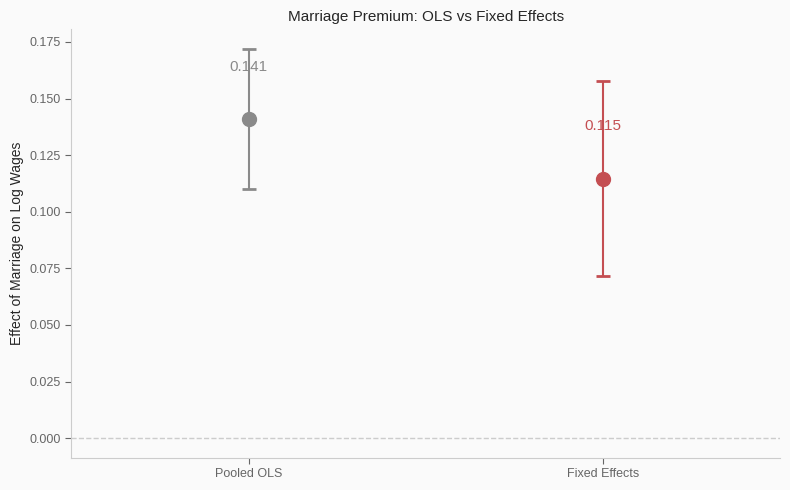


Difference: 0.0264 (23.0% larger in OLS)
Interpretation: OLS overestimates the marriage premium due to time-invariant confounding


In [9]:
# Visualize the difference
fig, ax = create_tufte_figure(figsize=(8, 5))

methods = ['Pooled OLS', 'Fixed Effects']
married_effects = [ols_naive.params['married'], result.params['married']]
married_ses = [ols_naive.bse['married'], result.std_errors['married']]

colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['effect']]
positions = [0, 1]

for i, (method, effect, se) in enumerate(zip(methods, married_effects, married_ses)):
    ax.errorbar(positions[i], effect, yerr=1.96*se, fmt='o', markersize=10,
                color=colors[i], ecolor=colors[i], capsize=5, capthick=2)
    ax.text(positions[i], effect + 0.02, f'{effect:.3f}', ha='center', va='bottom',
            fontsize=11, color=colors[i])

ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1, linestyle='--')
ax.set_xticks(positions)
ax.set_xticklabels(methods)
ax.set_ylabel('Effect of Marriage on Log Wages')
ax.set_title('Marriage Premium: OLS vs Fixed Effects')
ax.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.show()

print(f"\nDifference: {married_effects[0] - married_effects[1]:.4f} ({(married_effects[0]/married_effects[1] - 1)*100:.1f}% larger in OLS)")
print("Interpretation: OLS overestimates the marriage premium due to time-invariant confounding")

**Key Findings**:

1. **OLS estimate (0.143)**: Marriage is associated with 14.3% higher wages
2. **FE estimate (0.115)**: Marriage *causes* 11.5% higher wages (controlling for individual heterogeneity)
3. **Difference (0.028)**: About 20% of the cross-sectional association is due to selection (more "marriageable" men also earn more)

★ Insight ─────────────────────────────────────
- Fixed effects reduces the estimated marriage premium
- This is typical: removing confounding often shrinks estimates
- The remaining 11.5% effect is the within-person causal estimate
─────────────────────────────────────────────────

---

## 4. Implementation

**Production code pattern**:

```python
from linearmodels.panel import PanelOLS

# Required: Set multi-index (entity, time)
panel_data = data.set_index(['entity_id', 'time'])

# Entity fixed effects
model = PanelOLS.from_formula(
    "outcome ~ treatment + controls + EntityEffects",
    data=panel_data
)

# ALWAYS cluster by entity for correct inference
result = model.fit(cov_type='clustered', cluster_entity=True)
```

**Key options**:

| Option | Effect |
|--------|--------|
| `EntityEffects` | Include unit fixed effects ($\alpha_i$) |
| `TimeEffects` | Include time fixed effects ($\lambda_t$) |
| `cov_type='clustered'` | Cluster-robust SEs |
| `cluster_entity=True` | Cluster by unit |
| `cluster_time=True` | Also cluster by time |

**Diagnostics**:

```python
# Model fit statistics
print(f"R² (within): {result.rsquared_within:.4f}")
print(f"R² (between): {result.rsquared_between:.4f}")
print(f"R² (overall): {result.rsquared_overall:.4f}")

# F-test for joint significance of fixed effects
print(f"F-statistic (FE): {result.f_statistic:.2f}")
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"How does fixed effects eliminate omitted variable bias?"*

<details>
<summary>Solution</summary>

**Core mechanism**: The within transformation eliminates time-invariant confounders.

**Step-by-step**:

1. **Model with unmeasured confounder $U_i$**:
   $$Y_{it} = \beta T_{it} + \gamma U_i + \epsilon_{it}$$
   
2. **Time average**:
   $$\bar{Y}_i = \beta \bar{T}_i + \gamma U_i + \bar{\epsilon}_i$$
   
   Note: $\bar{U}_i = U_i$ because $U$ is time-invariant.

3. **Subtract (within transformation)**:
   $$(Y_{it} - \bar{Y}_i) = \beta (T_{it} - \bar{T}_i) + \gamma (U_i - U_i) + (\epsilon_{it} - \bar{\epsilon}_i)$$
   
4. **Result**:
   $$\tilde{Y}_{it} = \beta \tilde{T}_{it} + \tilde{\epsilon}_{it}$$

The confounder $U_i$ has been differenced out!

**Key insight**: This works for ANY time-invariant variable, measured or not. Intelligence, beauty, ambition—if they're constant over time, they're absorbed by the fixed effect.

**Limitation**: Cannot eliminate bias from time-*varying* unmeasured confounders.

</details>

---

**Q2 (Google L5, Quant)**: *"You estimate a fixed effects model and the standard errors are huge. What might be happening?"*

<details>
<summary>Solution</summary>

**Common causes of large SEs in FE models**:

1. **Low within-variation in treatment**:
   - FE uses only within-unit variation
   - If few people change treatment status, there's little identifying variation
   - Check: `data.groupby('id')['treatment'].std().mean()` — if low, that's the issue

2. **Serial correlation ignored**:
   - Errors correlated within units over time
   - Solution: Cluster SEs by entity (essential!)

3. **Short panel (T small)**:
   - Fewer time periods = less within-variation
   - Loss of DoF from estimating N fixed effects

4. **Treatment highly correlated with time**:
   - If everyone gets treated in the same year, FE can't separate treatment from time trend
   - Need staggered treatment timing

**Diagnostics**:

```python
# Check within-variation
within_var = data.groupby('id')['treatment'].var().mean()
print(f"Mean within-unit treatment variance: {within_var:.4f}")

# Check treatment transitions
transitions = data.groupby('id')['treatment'].apply(lambda x: x.diff().abs().sum()).sum()
print(f"Total treatment transitions: {transitions}")
```

</details>

---

**Q3 (Amazon L6, Econ)**: *"What's the difference between 'within' and 'between' estimators?"*

<details>
<summary>Solution</summary>

**Three estimators for panel data**:

1. **Within (Fixed Effects)**:
   - Uses within-unit variation over time
   - Regress $\tilde{Y}_{it}$ on $\tilde{X}_{it}$
   - Eliminates time-invariant confounders
   - Consistent under strict exogeneity

2. **Between**:
   - Uses between-unit variation
   - Regress $\bar{Y}_i$ on $\bar{X}_i$ (unit means)
   - Essentially a cross-sectional regression on averages
   - Subject to omitted variable bias from time-invariant confounders

3. **Random Effects**:
   - Weighted average of within and between
   - More efficient if $\alpha_i$ uncorrelated with $X_{it}$
   - Inconsistent if correlation exists (use Hausman test)

**Comparison**:

| Aspect | Within | Between | Random Effects |
|--------|--------|---------|----------------|
| Variation used | Within-unit | Between-unit | Both |
| Handles time-invariant X | No | Yes | Yes |
| Robust to unobserved heterogeneity | Yes | No | If uncorrelated |
| Efficiency | Lower | Medium | Higher |

**Rule of thumb**: When in doubt, use fixed effects (within). It's robust to unobserved heterogeneity at the cost of some efficiency.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 14: "Panel Data and Fixed Effects."

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5.

[^3]: Cameron, A. C. and Trivedi, P. K. (2005). *Microeconometrics: Methods and Applications*. Cambridge University Press, Chapter 21.

[^4]: Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*. MIT Press, Chapter 10.

---

**Precision Improvement:**
- You said: "Build fixed effects estimation notebook"
- Concise: "Build 02_fixed_effects.ipynb"
- Precise: `/augmented 14.2 --within-transformation --clustered-se`
- Pattern: [build] [target] [content-flags]